## Loading files and Environment

In [1]:
#%conda env export > environment.yaml

In [2]:
import os
import glob
import pandas as pd
import numpy as np
import sys
import pathlib
import sklearn
import numpy
import nltk
import wordcloud
import gensim
from wordcloud import WordCloud
from sklearn.metrics import classification_report
from sklearn.datasets import load_iris
from PIL import Image, ImageDraw, ImageFont
from nltk.corpus import stopwords
from collections import Counter
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

In [3]:
# Get current directory
current_dir = os.getcwd()
# Get parent directory
parent_dir = os.path.join(current_dir, '..')
# Append parent directory to sys.path
sys.path.append(parent_dir)
from src import data_cleaning as dc

In [4]:
cwd = pathlib.Path.cwd().parent
training_file_path = cwd.joinpath("datasets/EuansGuideData.xlsx")
test_file_path = cwd.joinpath("datasets/GoogleReviews")
print('path:', training_file_path)
print('path:', test_file_path)

path: /Users/mylene/BachelorsProject/Venue-Accessibility-Google-Reviews/datasets/EuansGuideData.xlsx
path: /Users/mylene/BachelorsProject/Venue-Accessibility-Google-Reviews/datasets/GoogleReviews


In [5]:
all_file_names = glob.glob(str(test_file_path) + "/*.csv")
google_df = [pd.read_csv(file_name, index_col=None, header=0) for file_name in all_file_names]
test_data = pd.concat(google_df, axis=0, ignore_index=True)

## Cleaning & Preprocessing

In [6]:
training_data = pd.read_excel(training_file_path)
clean_train_df = dc.clean_and_select(training_data, ["Aspect", "Rating", "Review", "Venue"])
clean_test_df = dc.clean_and_select(test_data, ["Name","Review Rate", "Review Text"])

/Users/mylene/BachelorsProject/Venue-Accessibility-Google-Reviews/notebooks/../src/data_cleaning.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Text"] = df["Text"].apply(lambda x: x.replace("\n", ' '))
/Users/mylene/BachelorsProject/Venue-Accessibility-Google-Reviews/notebooks/../src/data_cleaning.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_aspects["Venue"] = selected_aspects["Venue"].apply(lambda x: get_venue_name(x))
/Users/mylene/BachelorsProject/Venue-Accessibility-Google-Rev

In [7]:
display(clean_train_df[:10])
display(clean_test_df[:10])

,Aspect,Rating,Text,Venue,SentenceCount,Sentiment,Label
1,Transport & Parking,5.0,"There is disabled parking close to the doors, ...",dobbies garden centre perth,2,positive,1.0
7,Transport & Parking,4.5,"A ten minute walk from the luas, not much near...",bow lane dublin,1,positive,1.0
14,Toilets,4.5,"I did not use the toilets, but if you ring the...",jorvik viking centre york,1,positive,1.0
17,Transport & Parking,4.5,"It's situated on the high street, which has a ...",potter about burntisland,3,positive,1.0
19,Toilets,4.5,Clean and spacious with a grab rail on one sid...,potter about burntisland,3,positive,1.0
22,Transport & Parking,5.0,4 spaces next to the front door,dumfries ice bowl dumfries,1,positive,1.0
34,Transport & Parking,5.0,There is a large car park with a good number o...,the peak at stirling sports village stirling,4,positive,1.0
36,Toilets,4.5,There are quite a few accessible toilets thro...,the peak at stirling sports village stirling,6,positive,1.0
41,Toilets,4.0,"Accessible toilets on third, fourth and fifth ...",john lewis london,5,positive,1.0
44,Transport & Parking,4.0,There is blue badge parking right next to the ...,nuffield health edinburgh fitness wellbeing gy...,3,positive,1.0


,Name,Sentiment,Text,Label
0,Ellis,positive,"It was a bit quite when we went in, but don’t ...",1
1,Ellis,positive,Nice cozy place which serves very tasty burger...,1
2,Ellis,positive,Really nice place. One of my favourite burger ...,1
3,Ellis,negative,The Service was quite good but the burgers we ...,0
4,Ellis,positive,I had a very nice experience! The staff were r...,1
5,Ellis,positive,Ellis Gourmet Burger - Today (15.03.2018) I w...,1
6,Ellis,negative,"The taste was okay. Unfortunately, when we got...",0
7,Ellis,positive,The only disappointing thing about this place ...,1
8,Ellis,positive,Yesterday in the afternoon we had some burgers...,1
9,Ellis,positive,Really cosy. Has an actual fireplace. Great fo...,1


## Exploratory Data Analysis

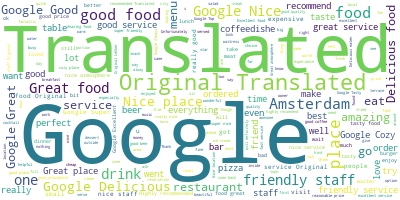

In [8]:
wordcloud = WordCloud(background_color='white', max_words=1000, contour_width=3, contour_color='steeleblue')

clustered_reviews_train = ','.join(list(clean_train_df['Text'].values))
clustered_reviews_test = ','.join(list(clean_test_df['Text'].values))
wordcloud.generate(clustered_reviews_train)
wordcloud.generate(clustered_reviews_test)
wordcloud.to_image()
wordcloud.to_image()

<AxesSubplot: title={'center': "Overview of Aspects in Euan's Guide data"}, xlabel='Aspect Types', ylabel='Amount of aspects'>

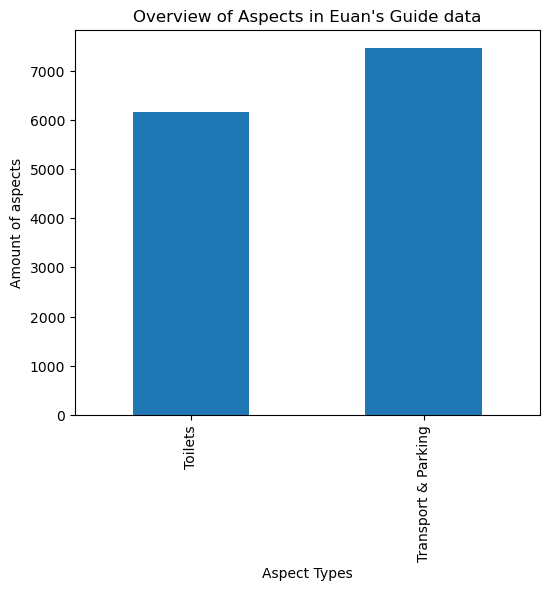

In [9]:
amount_per_aspect = clean_train_df.groupby(['Aspect']).count()
amount_per_aspect = amount_per_aspect['Text']
amount_per_aspect.plot(kind='bar', title="Overview of Aspects in Euan's Guide data", ylabel='Amount of aspects', xlabel='Aspect Types', figsize=(6,5))

<AxesSubplot: title={'center': "Overview of Sentiments in Euan's Guide data"}, xlabel='Sentiment Types', ylabel='Amount of Each Sentiment'>

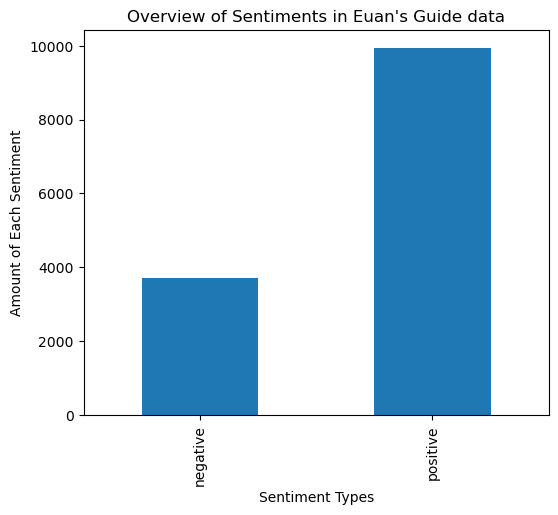

In [10]:
amount_per_sentiment = clean_train_df.groupby(['Sentiment']).count()
amount_per_sentiment = amount_per_sentiment['Text']
amount_per_sentiment.plot(kind='bar', title="Overview of Sentiments in Euan's Guide data", ylabel='Amount of Each Sentiment', xlabel='Sentiment Types', figsize=(6,5))

## Aspect Classification

### Pipeline setup

In [11]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier



In [12]:
vectorizer = CountVectorizer()
n = round(len(clean_train_df))
euans_reviews = clean_train_df.Text.values.tolist()
google_reviews = clean_test_df[:n].Text.values.tolist()
euans_labels = clean_train_df.Aspect.values.tolist()


In [13]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('clf', VotingClassifier([
        ('nb', MultinomialNB()),
        ('lr', LogisticRegression())
    ]))
])

In [14]:
parameters = {
    'vectorizer__max_df': (0.5, 0.75, 1.0),
    'vectorizer__ngram_range': ((1, 1), (1, 2)),
    'clf__voting': ('soft', 'hard'),
    'clf__nb__alpha': (0.5, 1),
    'clf__lr__C': (0.1, 1, 10),
}

In [15]:
grid_search = GridSearchCV(estimator=pipeline, param_grid=parameters, cv=5, n_jobs=5, verbose=1)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(euans_reviews, euans_labels, test_size=0.2, random_state=42)

In [17]:
import random

google_sample = random.sample(google_reviews, len(y_val))

In [18]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('clf',
                                        VotingClassifier(estimators=[('nb',
                                                                      MultinomialNB()),
                                                                     ('lr',
                                                                      LogisticRegression())]))]),
             n_jobs=5,
             param_grid={'clf__lr__C': (0.1, 1, 10), 'clf__nb__alpha': (0.5, 1),
                         'clf__voting': ('soft', 'hard'),
                         'vectorizer__max_df': (0.5, 0.75, 1.0),
                         'vectorizer__ngram_range': ((1, 1), (1, 2))},
             verbose=1)

In [19]:
y_pred = grid_search.predict(X_val)

In [20]:
google_pred = grid_search.predict(google_sample)

In [21]:
pos_labels = ['Toilets', 'Transport & Parking']

### Evaluation Metrics

In [22]:
valuation_report = classification_report(y_val, y_pred, labels=pos_labels)
evaluation_report = classification_report(y_val, google_pred, labels=pos_labels)
print("Euan's Guide Evaluation Report\n",valuation_report)
print("Google Reviews Evaluation Report\n",evaluation_report)
# save report as a text file
with open('../Results/google_aspect_classification_report.txt', 'w') as f:
    f.write(evaluation_report)
    
with open('../Results/euans_aspect_classification_report.txt', 'w') as f:
    f.write(valuation_report)

# # convert text file to PNG image
img = Image.new('RGB', (800, 800), color='white')
font = ImageFont.truetype('../media/Fonts/Roboto/Roboto-Black.ttf', 20)
draw = ImageDraw.Draw(img)

with open('../Results/google_aspect_classification_report.txt', 'r') as f:
    y = 0
    for line in f.readlines():
        draw.text((10, y), line, fill='black', font=font)
        y += 20

img.save('../Results/google_aspect_classification_report.png')

with open('../Results/euans_aspect_classification_report.txt', 'r') as f:
    y = 0
    for line in f.readlines():
        draw.text((10, y), line, fill='black', font=font)
        y += 20

img.save('../Results/euans_aspect_classification_report.png')


Euan's Guide Evaluation Report
                      precision    recall  f1-score   support

            Toilets       0.99      0.99      0.99      1218
Transport & Parking       0.99      0.99      0.99      1508

           accuracy                           0.99      2726
          macro avg       0.99      0.99      0.99      2726
       weighted avg       0.99      0.99      0.99      2726

Google Reviews Evaluation Report
                      precision    recall  f1-score   support

            Toilets       0.45      0.59      0.51      1218
Transport & Parking       0.56      0.43      0.49      1508

           accuracy                           0.50      2726
          macro avg       0.51      0.51      0.50      2726
       weighted avg       0.51      0.50      0.50      2726



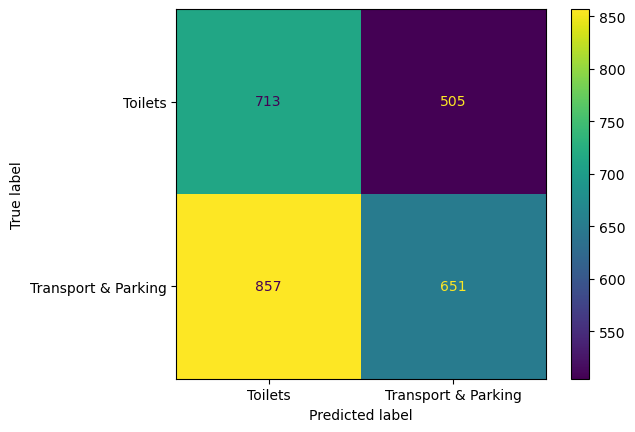

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, google_pred)

display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pos_labels)

display.plot()

## Sentiment Analysis

In [24]:
sentiment_labels = clean_train_df.Sentiment.values.tolist()
X2_train, X2_val, y2_train, y2_val = train_test_split(euans_reviews, sentiment_labels, test_size=0.2, random_state=42)

pipeline2 = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('clf', VotingClassifier([
        ('nb', MultinomialNB()),
        ('svm', SVC())
    ]))
])

In [25]:
sentiment_params = {
    'vectorizer__max_features': [1000, 5000],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'clf__voting': ['hard', 'soft'],
    'clf__weights': [[0.5, 0.5], [0.7, 0.3]],
    'clf__estimators': [
        [('nb', MultinomialNB(alpha=0.5)), ('svm', SVC(kernel='linear', C=1.0))],
        [('nb', MultinomialNB(alpha=1.0)), ('svm', SVC(kernel='rbf', C=10.0, gamma=0.1))]
    ]
}

In [26]:
grid_search2 = GridSearchCV(estimator=pipeline2, param_grid=sentiment_params, cv=5, n_jobs=5, verbose=1)
grid_search2.fit(X2_train, y2_train)
y2_pred = grid_search2.predict(X2_val)
google2_pred = grid_search2.predict(google_sample)
euans_report = classification_report(y2_val, y2_pred)
google_report = classification_report(google2_pred, y2_pred)

print('Euans Report\n', euans_report)
print('Google Report\n', google_report)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


KeyboardInterrupt: 

In [ ]:
# save report as a text file
with open('../Results/google_sentiment_analysis_report.txt', 'w') as f:
    f.write(google_report)
    
with open('../Results/euans_sentiment_analysis_report.txt', 'w') as f:
    f.write(euans_report)

# # convert text file to PNG image optimise this as you repeat this code.
img = Image.new('RGB', (800, 800), color='white')
font = ImageFont.truetype('../media/Fonts/Roboto/Roboto-Black.ttf', 20)
draw = ImageDraw.Draw(img)

with open('../Results/euans_sentiment_analysis_report.txt', 'r') as f:
    y = 0
    for line in f.readlines():
        draw.text((10, y), line, fill='black', font=font)
        y += 20

img.save('../Results/euans_sentiment_analysis_report.png')

with open('../Results/google_sentiment_analysis_report.txt', 'r') as f:
    y = 0
    for line in f.readlines():
        draw.text((10, y), line, fill='black', font=font)
        y += 20

img.save('../Results/google_sentiment_analysis_report.png')


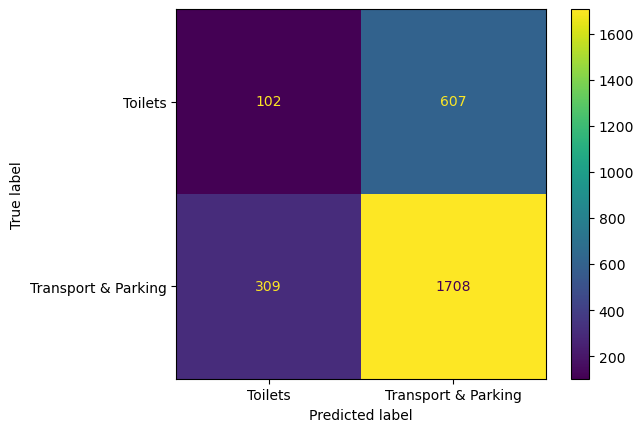

In [ ]:
cm2 = confusion_matrix(y2_val, google2_pred)

display2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=pos_labels)

display2.plot()

## Opinion Summarisation

Moved this part to Google Colab https://colab.research.google.com/drive/1NVzQ3vS6oaQ7EPFzzij1XbjDQT0QpOBO?usp=sharing

In [ ]:
#clean_test_df.to_csv('/Users/mylene/BachelorsProject/Venue-Accessibility-Google-Reviews/datasets/google_reviews.csv', index=False)
#clean_train_df.to_csv("/Users/mylene/BachelorsProject/Venue-Accessibility-Google-Reviews/datasets/euans_reviews.csv", index=False)

In [27]:
# from transformers import pipeline
# from textblob import TextBlob
# summariser = pipeline('summarization', model='distilbert-base-uncased')

# """
# We want the review text per venue, aspect and sentiment.
# """
# # Possibly vader could look at identifying the sentiment correctly.
# # [['Venue', 'Aspect', 'Sentiment', 'Text']]


# summaries = summariser(euans_reviews, max_length=50, min_length=10)

# reviews_per_venue = clean_train_df['summary'] = [summary['Summarised Review'] for summary in summaries]
# reviews_per_venue.head()


# # Group all reviews per venue
# # generate a summary of the sentiment and aspects for that venue.

## Lex Rank implementation

In [28]:
import sumy
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

long_reviews = clean_train_df[clean_train_df['SentenceCount'] > 4]
long_reviews


,Aspect,Rating,Text,Venue,SentenceCount,Sentiment,Label
36,Toilets,4.5,There are quite a few accessible toilets thro...,the peak at stirling sports village stirling,6,positive,1.0
41,Toilets,4.0,"Accessible toilets on third, fourth and fifth ...",john lewis london,5,positive,1.0
46,Toilets,4.5,As I mentioned above the toilet is also a chan...,nuffield health edinburgh fitness wellbeing gy...,5,positive,1.0
160,Toilets,4.0,I visited the accessible loo near reception. T...,lee valley hockey and tennis centre london,7,positive,1.0
244,Transport & Parking,4.0,Based in the City Centre of Newcastle - there ...,discovery museum newcastle upon tyne,9,positive,1.0
...,...,...,...,...,...,...,...
56362,Toilets,5.0,On entering the museum there are three sets of...,the charterhouse london,6,positive,1.0
56409,Toilets,4.0,There is a small changing places toilet here. ...,burnby hall gardens museum york,5,positive,1.0
56451,Transport & Parking,5.0,About 200 yards from main railway. Good paveme...,beefeater dundee,5,positive,1.0
56469,Transport & Parking,5.0,Parking was good. We used our own WAV Wheelch...,cadbury world birmingham,5,positive,1.0


In [29]:
summaries = []
i = 0
for review in long_reviews.Text.values.tolist():
    parser = PlaintextParser.from_string(review,Tokenizer('english'))
    i+=1
    lex_rank_summarizer = LexRankSummarizer()
    summaries.append(lex_rank_summarizer(parser.document, sentences_count=2)) 
print(i)

1155


In [30]:
pd.set_option('display.max_colwidth', None)

In [31]:
long_reviews['Lex Rank Summary'] = summaries

long_reviews.head()

/var/folders/qk/lcnvt9x13sd1_944mzdqthnh0000gn/T/ipykernel_99257/2328567444.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_reviews['Lex Rank Summary'] = summaries


,Aspect,Rating,Text,Venue,SentenceCount,Sentiment,Label,Lex Rank Summary
36,Toilets,4.5,"There are quite a few accessible toilets throughout the centre. The smallest of these is located just next to the cafe at the main entrance. The other accessible toilets are a good size all with showering facilities. These are scattered throughout the sports centre including at least 2 upstairs near the gym, 2 near the sports halls, 1 in the ice rink and 1 in the NCA. I did come across one of the toilets that had a bed and portable hoist in but not sure of weight limits etc. I think it would be advisable",the peak at stirling sports village stirling,6,positive,1.0,"(There are quite a few accessible toilets throughout the centre., The smallest of these is located just next to the cafe at the main entrance.)"
41,Toilets,4.0,"Accessible toilets on third, fourth and fifth floors. But: (i) There is no signage telling you where the accessible toilets are, whereas there is plenty of signage pointing you to the 'normal' toilets. (ii) Far more seriously, in two of the accessible toilets, 3rd and 4th floors, I found the red emergency cord tied up so that the end of it was about five feet above floor level. This means that anyone who falls over and is stuck on the floor cannot summon assistance. Very very silly and dangerous.",john lewis london,5,positive,1.0,"(Accessible toilets on third, fourth and fifth floors., But: (i) There is no signage telling you where the accessible toilets are, whereas there is plenty of signage pointing you to the 'normal' toilets.)"
46,Toilets,4.5,As I mentioned above the toilet is also a changing room / shower room with seating and rails. There is also a red cord next to the shower although this doesn’t reach to the floor yet. Inside this room there are also two low down accessible lockers which are very spacious. I have taken pictures and written captions which you can view. I dropped a half star as there was not a red cord next to the toilet which I think is a big safety issue.,nuffield health edinburgh fitness wellbeing gym edinburgh,5,positive,1.0,"(Inside this room there are also two low down accessible lockers which are very spacious., I dropped a half star as there was not a red cord next to the toilet which I think is a big safety issue.)"
160,Toilets,4.0,"I visited the accessible loo near reception. The signs were there but really really tiny. The loo was good - reasonable size, grab rails etc. The door was manual but very light touch to open. Only downside was that there's only a single male and a single female able-bodied loo nearby - so of course everyone used the accessible loo rather than wait. I did notice another block of loos nearby the courts. The loo I visited was not radar key operated.",lee valley hockey and tennis centre london,7,positive,1.0,"(I visited the accessible loo near reception., The signs were there but really really tiny.)"
244,Transport & Parking,4.0,"Based in the City Centre of Newcastle - there are a lot of Transport options available to you. Metro - the local underground style train service is cheap, accessible and mostly(!) reliable with the nearest Station being Central Station. This is a 10-15 minute accessible walk or roll to the Discovery Museum. Bus - local Bus Stations include Haymarket and Eldon Square with quite a long walk to the Museum from either station. I’d recommend this route if you wanted to see the sights of Newcastle or stop for lunch on the way to the Venue. There are some closer stops available via local route services and all Public Transport in and around the North East should be Accessible and includes spaces for at least one chair. Parking - There are a limited number of Disabled parking bays available here - definitely something that could be improved. But the few that are here are close to the entrance, have ample space around them and don’t have any obstructions to the entrance.",discovery museum newcastle upon tyne,9,positive,1.0,"(Based in the City Cent

## Latenet Semantic Analysis Approach

In [32]:
from sumy.summarizers.lsa import LsaSummarizer

lsa_summarizer=LsaSummarizer()
lsa_summaries = []
for review in long_reviews.Text.values.tolist():
    lsa_parser=PlaintextParser.from_string(review,Tokenizer('english'))
    lsa_summaries.append(lsa_summarizer(lsa_parser.document,2))

In [33]:
long_reviews['LSA Summaries'] = lsa_summaries

/var/folders/qk/lcnvt9x13sd1_944mzdqthnh0000gn/T/ipykernel_99257/1693373636.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_reviews['LSA Summaries'] = lsa_summaries


In [34]:
long_reviews.head()

,Aspect,Rating,Text,Venue,SentenceCount,Sentiment,Label,Lex Rank Summary,LSA Summaries
36,Toilets,4.5,"There are quite a few accessible toilets throughout the centre. The smallest of these is located just next to the cafe at the main entrance. The other accessible toilets are a good size all with showering facilities. These are scattered throughout the sports centre including at least 2 upstairs near the gym, 2 near the sports halls, 1 in the ice rink and 1 in the NCA. I did come across one of the toilets that had a bed and portable hoist in but not sure of weight limits etc. I think it would be advisable",the peak at stirling sports village stirling,6,positive,1.0,"(There are quite a few accessible toilets throughout the centre., The smallest of these is located just next to the cafe at the main entrance.)","(There are quite a few accessible toilets throughout the centre., The other accessible toilets are a good size all with showering facilities.)"
41,Toilets,4.0,"Accessible toilets on third, fourth and fifth floors. But: (i) There is no signage telling you where the accessible toilets are, whereas there is plenty of signage pointing you to the 'normal' toilets. (ii) Far more seriously, in two of the accessible toilets, 3rd and 4th floors, I found the red emergency cord tied up so that the end of it was about five feet above floor level. This means that anyone who falls over and is stuck on the floor cannot summon assistance. Very very silly and dangerous.",john lewis london,5,positive,1.0,"(Accessible toilets on third, fourth and fifth floors., But: (i) There is no signage telling you where the accessible toilets are, whereas there is plenty of signage pointing you to the 'normal' toilets.)","(But: (i) There is no signage telling you where the accessible toilets are, whereas there is plenty of signage pointing you to the 'normal' toilets., This means that anyone who falls over and is stuck on the floor cannot summon assistance.)"
46,Toilets,4.5,As I mentioned above the toilet is also a changing room / shower room with seating and rails. There is also a red cord next to the shower although this doesn’t reach to the floor yet. Inside this room there are also two low down accessible lockers which are very spacious. I have taken pictures and written captions which you can view. I dropped a half star as there was not a red cord next to the toilet which I think is a big safety issue.,nuffield health edinburgh fitness wellbeing gym edinburgh,5,positive,1.0,"(Inside this room there are also two low down accessible lockers which are very spacious., I dropped a half star as there was not a red cord next to the toilet which I think is a big safety issue.)","(There is also a red cord next to the shower although this doesn’t reach to the floor yet., I have taken pictures and written captions which you can view.)"
160,Toilets,4.0,"I visited the accessible loo near reception. The signs were there but really really tiny. The loo was good - reasonable size, grab rails etc. The door was manual but very light touch to open. Only downside was that there's only a single male and a single female able-bodied loo nearby - so of course everyone used the accessible loo rather than wait. I did notice another block of loos nearby the courts. The loo I visited was not radar key operated.",lee valley hockey and tennis centre london,7,positive,1.0,"(I visited the accessible loo near reception., The signs were there but really really tiny.)","(Only downside was that there's only a single male and a single female able-bodied loo nearby - so of course everyone used the accessible loo rather than wait., I did notice another block of loos nearby the courts.)"
244,Transport & Parking,4.0,"Based in the City Centre of Newcastle - there are a lot of Transport options available to you. Metro - the local underground style train service is cheap, accessible and mostly(!) reliable with the nearest Station being Central Station. This is a 10-15 minute accessible walk 